This model uses Random Forest, Histogram Gradient, Catboost and XGboost models to evaluate the Compressive strength of cement

Final cross_val_score (accuracy = 'r2') = 90% (approx)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
train=pd.read_csv('Concrete_Data.csv')

In [4]:
train.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [5]:
train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Cement (component 1)(kg in a m^3 mixture)              1030 non-null   float64
 1   Blast Furnace Slag (component 2)(kg in a m^3 mixture)  1030 non-null   float64
 2   Fly Ash (component 3)(kg in a m^3 mixture)             1030 non-null   float64
 3   Water  (component 4)(kg in a m^3 mixture)              1030 non-null   float64
 4   Superplasticizer (component 5)(kg in a m^3 mixture)    1030 non-null   float64
 5   Coarse Aggregate  (component 6)(kg in a m^3 mixture)   1030 non-null   float64
 6   Fine Aggregate (component 7)(kg in a m^3 mixture)      1030 non-null   float64
 7   Age (day)                                              1030 non-null   int64  
 8   Concrete compressive strength(MPa, megapascals)  

In [6]:
#Renaming the columns to make improve the workability
r_col=['cement', 'B_Furnace','Fly_ash','water','s_plastic','C_agg', 'F_agg','age', 'c_str']
i=0
for col in train.columns:
    train.rename(columns={col:r_col[i]},inplace=True)
    i=i+1

In [7]:
#adding water/cement ratio as it a strong indicator for c_str
train['w/c']=train['water']/train['cement']

In [8]:
train.columns

Index(['cement', 'B_Furnace', 'Fly_ash', 'water', 's_plastic', 'C_agg',
       'F_agg', 'age', 'c_str', 'w/c'],
      dtype='object')

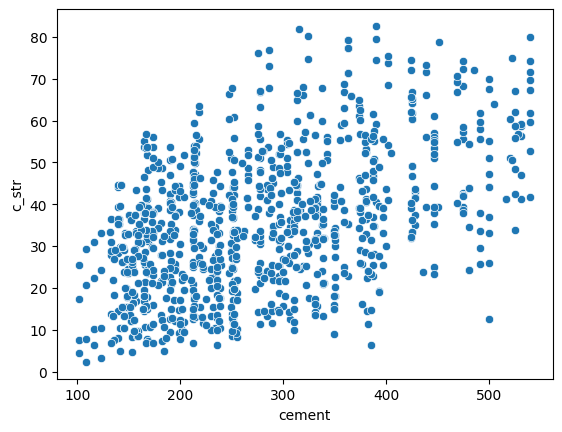

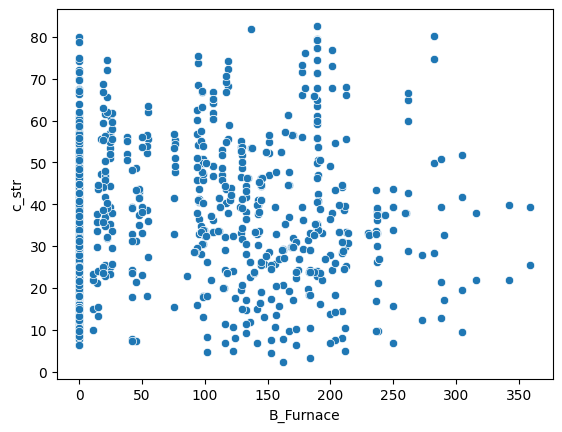

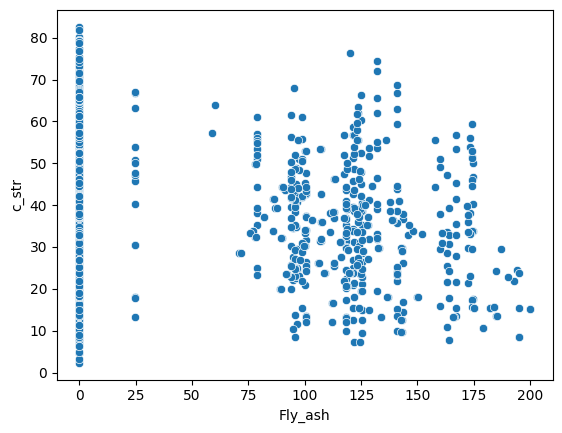

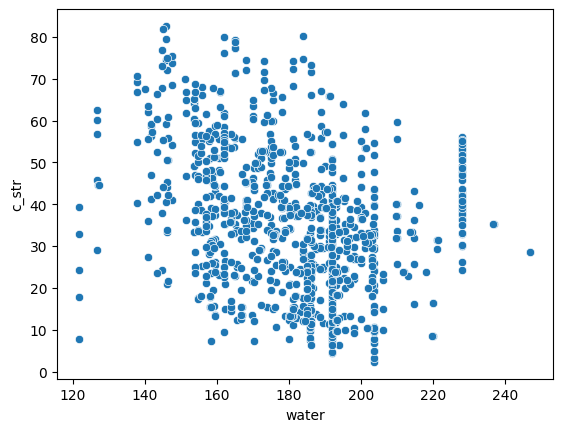

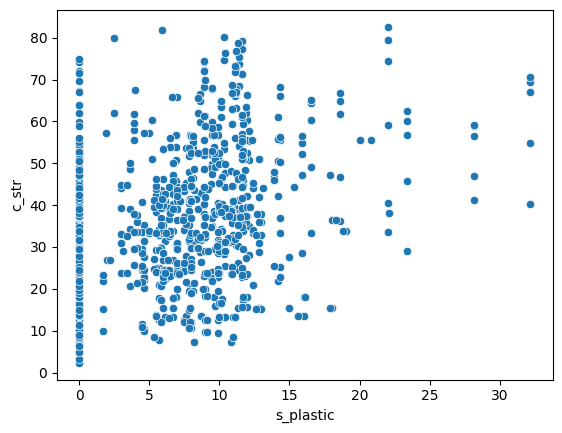

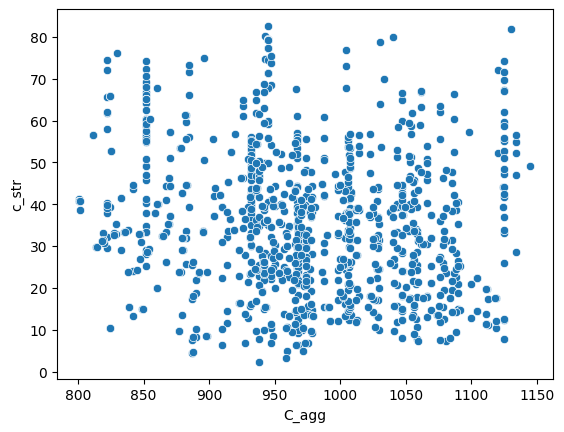

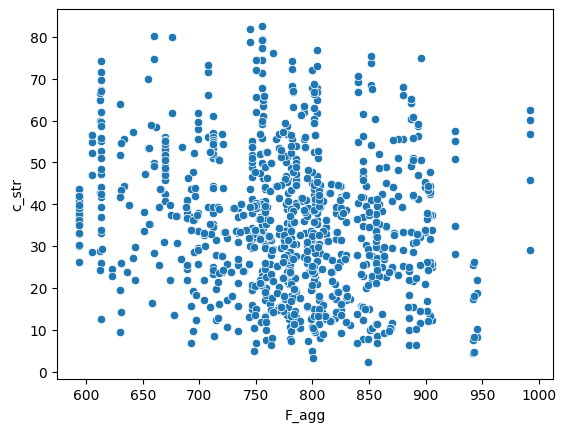

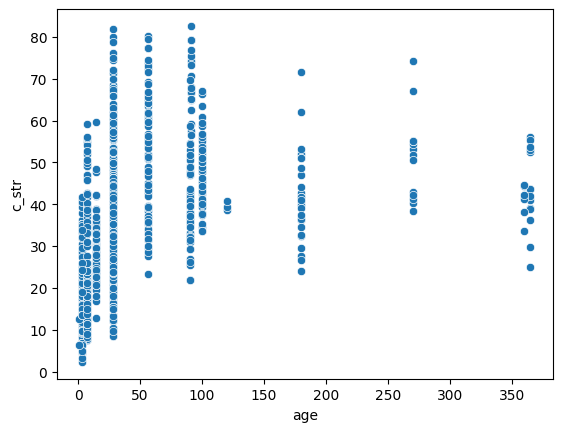

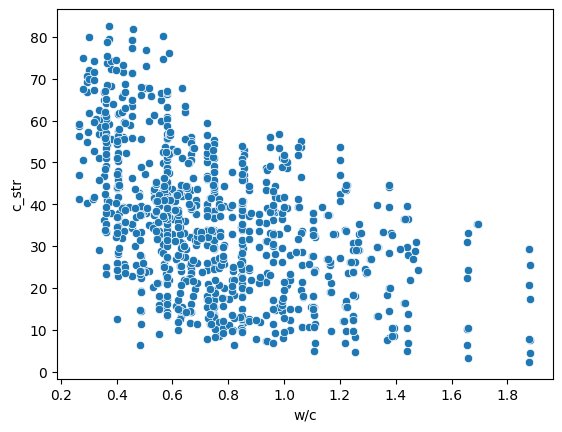

In [9]:
#plotting scatter plots for all the features against c_str to find any correlation graphically
for col in train.columns.drop(labels='c_str'):
    sns.scatterplot(x=train[col], y=train['c_str'])
    plt.xlabel(col)
    plt.ylabel('c_str')
    plt.show()

In [10]:
#Checking if gaps need to be filled
train.isna().sum()

cement       0
B_Furnace    0
Fly_ash      0
water        0
s_plastic    0
C_agg        0
F_agg        0
age          0
c_str        0
w/c          0
dtype: int64

<AxesSubplot: >

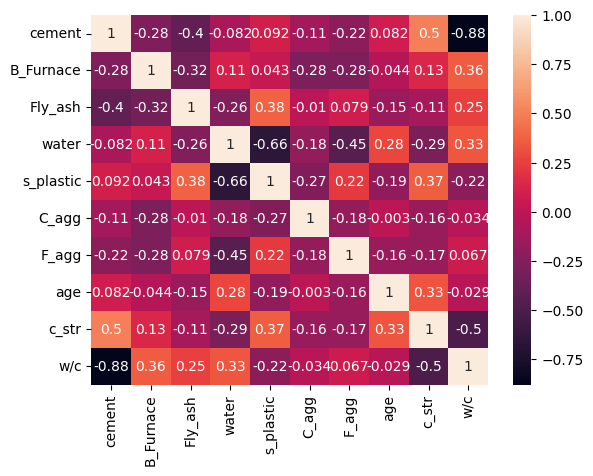

In [11]:
#fidning correlation between all the features numerically
sns.heatmap(train.corr(), annot=True)

It is evident from the heatmap that C_agg and F_agg have almost similar correlation to c_str.

Therefore, they can be clubbed together as 'agg' to make the model more simpler for further computation

In [12]:
train.describe()

,cement,B_Furnace,Fly_ash,water,s_plastic,C_agg,F_agg,age,c_str,w/c
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961,0.748266
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742,0.314005
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000,0.266893
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000,0.533333
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000,0.675349
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000,0.935165
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000,1.882353


In [13]:
#Adding up columns F_agg and C_agg to 'agg'
train['agg']=np.sqrt(((train['F_agg'])**2 + (train['C_agg'])**2)/2)

In [14]:
#dropping the redundant columns like water, cement, C_agg, F_agg as their inputs are used in some other column
train.drop(columns=['C_agg','F_agg','cement','water'], inplace=True)

In [37]:
#Creating the feature matrix(X) and dependent variable vector(y)
X=train.iloc[:,[0,1,2,3,5,6]].values
y=train.iloc[:,-3].values

In [38]:
#Splitting the dataset into training and test set
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.25, shuffle=True)

In [46]:
#Feature Scaling using a normalizer(Standard scaler can also be used)
from sklearn.preprocessing import StandardScaler,Normalizer
sc=StandardScaler()
nr=Normalizer()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [47]:
print(X_train)

[[-8.63152715e-01  9.52597405e-01 -4.54832573e-02  1.68596550e-01
   2.75519810e-01  3.56187689e-01]
 [-8.63152715e-01  1.60453676e+00  9.85080096e-01 -2.22625818e-01
  -4.49082582e-01 -1.30208118e-03]
 [-8.63152715e-01 -8.53003117e-01 -1.02811102e+00 -2.78513779e-01
  -8.95423630e-01  9.41240479e-01]
 ...
 [ 9.32487422e-01 -8.53003117e-01 -1.02811102e+00 -6.22617888e-01
   1.06438590e+00  8.00975793e-02]
 [ 2.23311127e+00 -8.53003117e-01 -1.02811102e+00 -6.24577777e-01
   7.90327677e-01 -1.71288011e+00]
 [-8.63152715e-01  1.35855606e+00  4.39665838e-01 -2.78660010e-01
   1.55458602e+00  1.86725183e-01]]


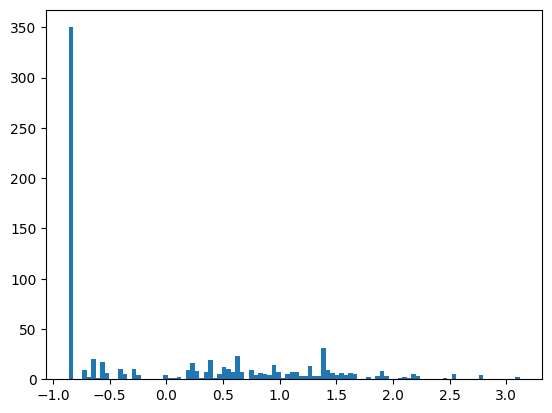

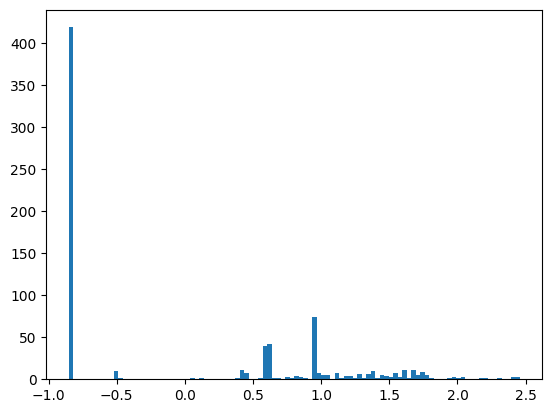

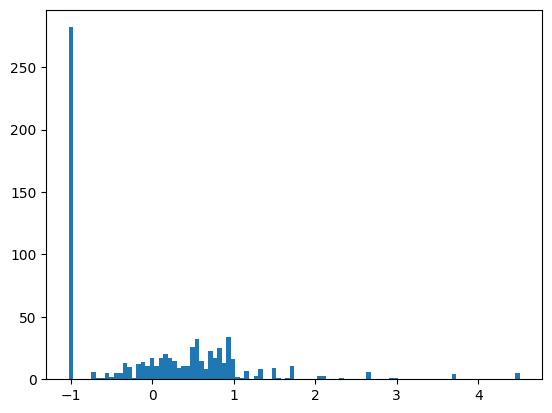

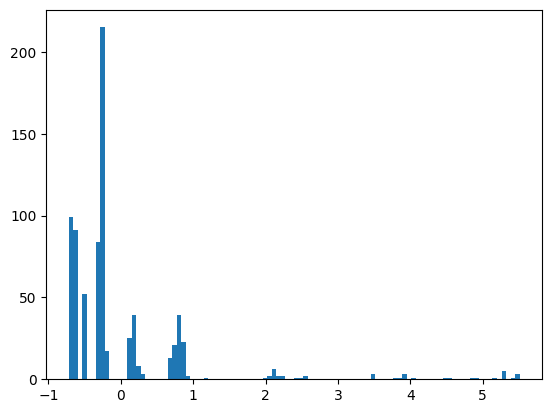

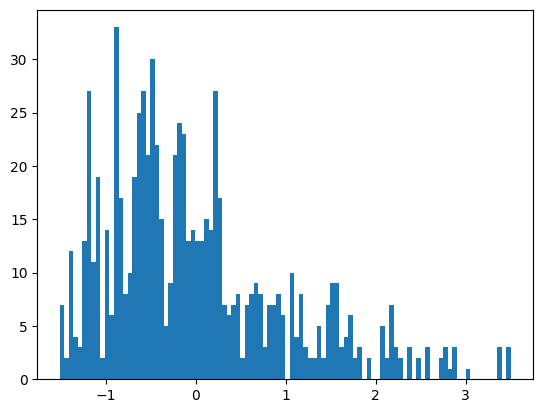

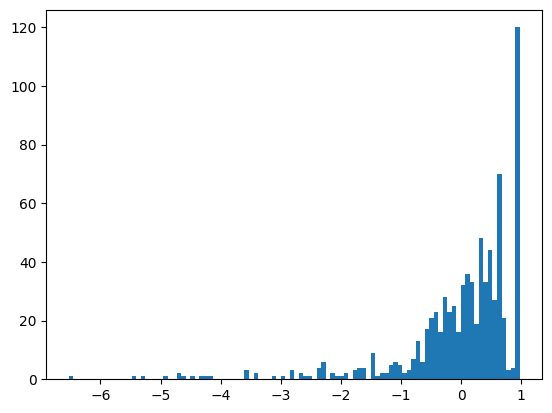

In [48]:
#Plotting the distribution of all features
for i in range(0, len(X_train[0])):
    plt.hist(X_train[:,i], bins=100)
    plt.show()

In [49]:
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

Random Forest Regressor

In [50]:
rn=RandomForestRegressor()

In [51]:
#Using RandomizedSearchCV to find the best hyperparameters in the least time
gs_rn=RandomizedSearchCV(estimator=rn, param_distributions=[{'n_estimators':[100,200,300,400,600,800,1000],
                                                             'criterion':['squared_error','absolute_error','friedman_mse','poisson'],
                                                             'max_features':['sqrt','log2',None],
                                                             'oob_score':[True, False]}],n_jobs=-1, scoring='r2',cv=10)
gs_rn.fit(X_train,y_train)

RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions=[{'criterion': ['squared_error',
                                                       'absolute_error',
                                                       'friedman_mse',
                                                       'poisson'],
                                         'max_features': ['sqrt', 'log2', None],
                                         'n_estimators': [100, 200, 300, 400,
                                                          600, 800, 1000],
                                         'oob_score': [True, False]}],
                   scoring='r2')

In [53]:
print(gs_rn.best_score_)
print(gs_rn.best_params_)

0.8883197897989371
{'oob_score': False, 'n_estimators': 300, 'max_features': 'sqrt', 'criterion': 'poisson'}


In [54]:
import sklearn
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

In [55]:
cross_val_score(gs_rn, X_train, y_train, scoring='r2').mean()

0.8787697291703198

In [56]:
svr=SVR()
svr.fit(X_train,y_train)

SVR()

In [57]:
grid_search=RandomizedSearchCV(estimator=svr, param_distributions=[{'C':[0.25,0.5,0.75,1],'kernel':['rbf','sigmoid','poly'],'gamma':[0.2,0.4,0.6,0.8,1]},
                                                    {'C':[0.25,0.5,0.75,1],'kernel':['linear']}],cv=10,n_jobs=-1,scoring='r2')
grid_search.fit(X_train,y_train)
print(grid_search.best_score_)
print(grid_search.best_params_)

0.6208012342164314
{'kernel': 'linear', 'C': 0.25}


XGBoost

In [58]:
xgb=XGBRegressor()

In [59]:
param_grid = {
    'n_estimators': [20, 50, 100, 250, 500,1000],
    'colsample_bytree': [0.2, 0.5, 0.7, 0.8, 1],
    'max_depth': [2, 5, 10, 15, 20, 25, None],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [1, 1.5, 2],
    'subsample': [0.5,0.6,0.7, 0.8, 0.9],
    'learning_rate':[.01,0.1,0.2,0.3,0.5, 0.7, 0.9],
    'gamma':[0,.01,.1,1,10,100],
    'min_child_weight':[0,.01,0.1,1,10,100],
    'sampling_method': ['uniform', 'gradient_based']
}

gs_xgb = RandomizedSearchCV(xgb, param_distributions= param_grid, n_iter=400, cv = 5, verbose = True, n_jobs = -1, scoring='r2')
gs_xgb.fit(X_train,y_train)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                   param_distributions={'colsample_bytree': [0.2, 0.5, 0.7, 0.8,
                                                             1],
                                        'gamma': [0, 0.01, 0.1, 1, 10, 100],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3,
                                                          0.5, 0.7, 0.9],
                                        'max_depth': [2, 5, 10, 15, 20, 25,
                                                      None],
                                        'min_child_weight': [0, 0.01, 0.1, 1,
                                                             10, 100],
                                        'n_estimators': [20, 50, 100, 250, 500,
                                                         1000],
                                        'reg_alpha': [0, 0.5, 1],
                                        'reg_lambda': [1, 1.5, 2],
                                        'sampling_method': ['uniform',
                                                            'gradient_based'],
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9]},
                   scoring='r2', verbose=True)

In [60]:
print(gs_xgb.best_score_)

0.906718603889234


CatBoost Regressor

In [61]:
cb=CatBoostRegressor()
cb.fit(X_train, y_train)

Learning rate set to 0.039303
0:	learn: 16.2063308	total: 1.91ms	remaining: 1.9s
1:	learn: 15.8565472	total: 3.43ms	remaining: 1.71s
2:	learn: 15.4848483	total: 4.95ms	remaining: 1.64s
3:	learn: 15.1706628	total: 6.3ms	remaining: 1.57s
4:	learn: 14.8243383	total: 7.75ms	remaining: 1.54s
5:	learn: 14.4890196	total: 9.71ms	remaining: 1.61s
6:	learn: 14.1638313	total: 12.7ms	remaining: 1.8s
7:	learn: 13.8463063	total: 14.8ms	remaining: 1.83s
8:	learn: 13.5142597	total: 17.1ms	remaining: 1.89s
9:	learn: 13.2147080	total: 19.2ms	remaining: 1.9s
10:	learn: 12.9060889	total: 20.7ms	remaining: 1.86s
11:	learn: 12.6311432	total: 22.1ms	remaining: 1.82s
12:	learn: 12.3665499	total: 23.9ms	remaining: 1.81s
13:	learn: 12.1036749	total: 25.9ms	remaining: 1.82s
14:	learn: 11.8528514	total: 27.5ms	remaining: 1.81s
15:	learn: 11.5993223	total: 28.9ms	remaining: 1.78s
16:	learn: 11.3867314	total: 30.4ms	remaining: 1.76s
17:	learn: 11.1761562	total: 31.8ms	remaining: 1.73s
18:	learn: 10.9711386	total: 3

In [62]:
cross_val_score(cb, X_train, y_train, scoring='r2').mean()

Learning rate set to 0.037935
0:	learn: 16.2722886	total: 2.61ms	remaining: 2.61s
1:	learn: 15.9215702	total: 4.83ms	remaining: 2.41s
2:	learn: 15.5677100	total: 6.55ms	remaining: 2.18s
3:	learn: 15.2496770	total: 8.45ms	remaining: 2.1s
4:	learn: 14.9086561	total: 10.2ms	remaining: 2.04s
5:	learn: 14.5888135	total: 12.1ms	remaining: 2.01s
6:	learn: 14.2754358	total: 14.1ms	remaining: 2s
7:	learn: 13.9522379	total: 15.9ms	remaining: 1.97s
8:	learn: 13.6607789	total: 18.2ms	remaining: 2s
9:	learn: 13.3603208	total: 19.9ms	remaining: 1.97s
10:	learn: 13.0637832	total: 21.5ms	remaining: 1.93s
11:	learn: 12.7877807	total: 23.3ms	remaining: 1.92s
12:	learn: 12.5202731	total: 24.8ms	remaining: 1.89s
13:	learn: 12.2496423	total: 26.4ms	remaining: 1.86s
14:	learn: 12.0217934	total: 28ms	remaining: 1.83s
15:	learn: 11.7772582	total: 29.4ms	remaining: 1.81s
16:	learn: 11.5595212	total: 31.1ms	remaining: 1.8s
17:	learn: 11.3328491	total: 33ms	remaining: 1.8s
18:	learn: 11.1210285	total: 35.1ms	rem

0.912009052798415

Histogram Gradient Boosting

In [63]:
hs=HistGradientBoostingRegressor()
hs.fit(X_train,y_train)

HistGradientBoostingRegressor()

In [64]:
rs_hs=RandomizedSearchCV(hs, param_distributions={'loss':['squared_error', 'absolute_error', 'huber', 'quantile'],'learning_rate':[0.01,0.1,0.2,0.4,0.8,1],'max_iter':[100,200,300,400,800,1000]},n_jobs=-1,cv=5,verbose=True)

In [65]:
cross_val_score(rs_hs, X_train, y_train, scoring='r2').mean()

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


0.8863139785546587

Voting regressor - ensembles all the models and remove any chance of overfitting

In [66]:
vr=VotingRegressor(estimators=[('rn',gs_rn),('xgb',gs_xgb),('hs',rs_hs),('cb',cb)])
cross_val_score(vr, X_train, y_train, scoring='r2').mean()

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Learning rate set to 0.037935
0:	learn: 16.2722886	total: 2.14ms	remaining: 2.14s
1:	learn: 15.9215702	total: 3.93ms	remaining: 1.96s
2:	learn: 15.5677100	total: 5.67ms	remaining: 1.88s
3:	learn: 15.2496770	total: 7.36ms	remaining: 1.83s
4:	learn: 14.9086561	total: 9.2ms	remaining: 1.83s
5:	learn: 14.5888135	total: 10.9ms	remaining: 1.8s
6:	learn: 14.2754358	total: 12.7ms	remaining: 1.8s
7:	learn: 13.9522379	total: 14.5ms	remaining: 1.79s
8:	learn: 13.6607789	total: 16.2ms	remaining: 1.79s
9:	learn: 13.3603208	total: 17.9ms	remaining: 1.77s
10:	learn: 13.0637832	total: 19.5ms	remaining: 1.76s
11:	learn: 12.7877807	total: 21.2ms	remaining: 1.75s
12:	learn: 12.5202731	total: 23ms	remaining: 1.74s
13:	learn: 12.2496423	total: 24.8ms	remaining: 1.74s
14:	learn: 12.0217934	total: 26.5ms	remaining: 1.74s
15:	learn: 11.7772582	total: 28.6ms	remaining: 1.76s
16:	learn: 1

0.9060822952508527

Hence - Final cross_val_score = 90%